In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import arviz as az

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.9.3


Running on PyMC3 v3.9.3


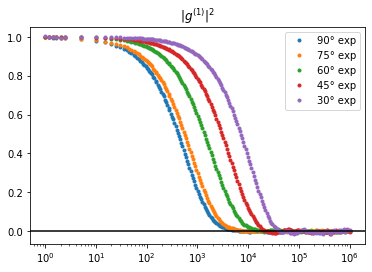

In [2]:
from MultiAngleDls import multiAngleDls

#filelist = ['test_data/PS_300nm_90degree.dat']
filelist = ['test_data/PS_100-200-500nm=1-1-5_{}.dat'.format(i+1) for i in range(4,9)]

data = multiAngleDls(filelist, d_min=0, d_max=800, d_num=30, log_d=False)
data.plotOriginalData()  

In [3]:
model = pm.Model()

# 3 numbers that may be used directly
n = data.d.size                       # d number
R = data.angleNum                     # angle number

# second derivative operator matrix
# for prior use
L2 = np.zeros((n, n))
for j in range(L2.shape[0]-2):
    L2[j, j], L2[j, j+1], L2[j, j+2] = 1, -2, 1

L1 = np.zeros((n, n))
for j in range(L1.shape[0]-1):
    L1[j, j], L1[j, j+1] = -1, 1


######## 构建 pN #########
from pymc3.distributions.continuous import BoundedContinuous
from pymc3.distributions.dist_math import bound

class pN(BoundedContinuous):

    def __init__(self, lower=np.zeros((n, 1)), L=L2, *args, **kwargs):
        self.lower = lower = tt.as_tensor_variable(lower)
        self.L = L = tt.as_tensor_variable(L)

        super().__init__(lower=lower,  *args, **kwargs)

    def logp(self, value):
        # value here is N
        lower = self.lower
        L = self.L
        # tt.prod(tt.sgn(value)+1)
        return bound(-1*tt.sum(tt.dot(L, value)**2), value >= lower)
#############################


with model:

    # prior distribution
    #N = pm.DensityDist('N', prior, shape=(n,1))
    N = pN('N', lower=np.zeros((n, 1)), L=L2, shape=(n,1), testval=np.ones((n, 1)))
    s = 0.05
    beta = 1 / (2*s**2)
    sigma = pm.Gamma('sigma', alpha=0.5, beta=beta, shape=R)

    # likelihood function
    g1square_obs = []
    for r in range(R):
        M = data.g1square_theta_list[r].size
        C = data.C_theta_list[r]
        C = C.reshape((C.size, 1))
        F = data.F_theta_list[r]
        g1square_theo = ( (1/tt.sum(C*N))*tt.dot(F, N) )**2

        #like = likelihood('like', g1square_theo=g1square_theo, M=M, shape=(M,1), testval=testg1square, observed=data.g1square_theta_list[0])
        g1square_obs.append(
            pm.Normal('g1square_obs_{}'.format(r), mu=g1square_theo, sigma=sigma[r], shape=(M, 1), observed=data.g1square_theta_list[r])
        )
        

In [4]:
with model:
    #step = pm.Metropolis()

    #step = pm.HamiltonianMC(target_accept=0.95)
    #trace = pm.sample(1000, step=step, cores=8, chains=8, tune=5000, discard_tuned_samples=True)
    
    #step = pm.Slice()
    #trace = pm.sample(10000, step=step, cores=8, chains=8, tune=50000, discard_tuned_samples=True)
    
    step = pm.NUTS(target_accept=0.95)
    trace = pm.sample(draws=50000, step=step, cores=8, chains=8, tune=200000, discard_tuned_samples=True)

trace['N'].shape

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, N]


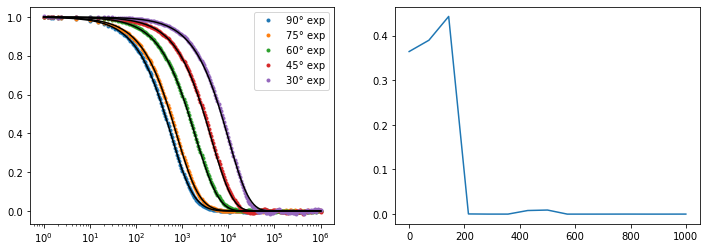

In [15]:
N_result = np.sum(trace['N'], axis=0) / trace['N'].shape[0]
#N_result = np.zeros((20,1))
#N_result = np.zeros_like(N_result)
#N_result[2,0], N_result[5,0], N_result[7,0] = 70, 2, 1
data.N = N_result
data.plotResult_g1square()

In [ ]:
pm.save_trace(trace, './result_trace/PS_100-200-500nm=1-1-5__trace_d-0-800-30pts_mcmc200k-20k')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97288707d0>,
      dtype=object)

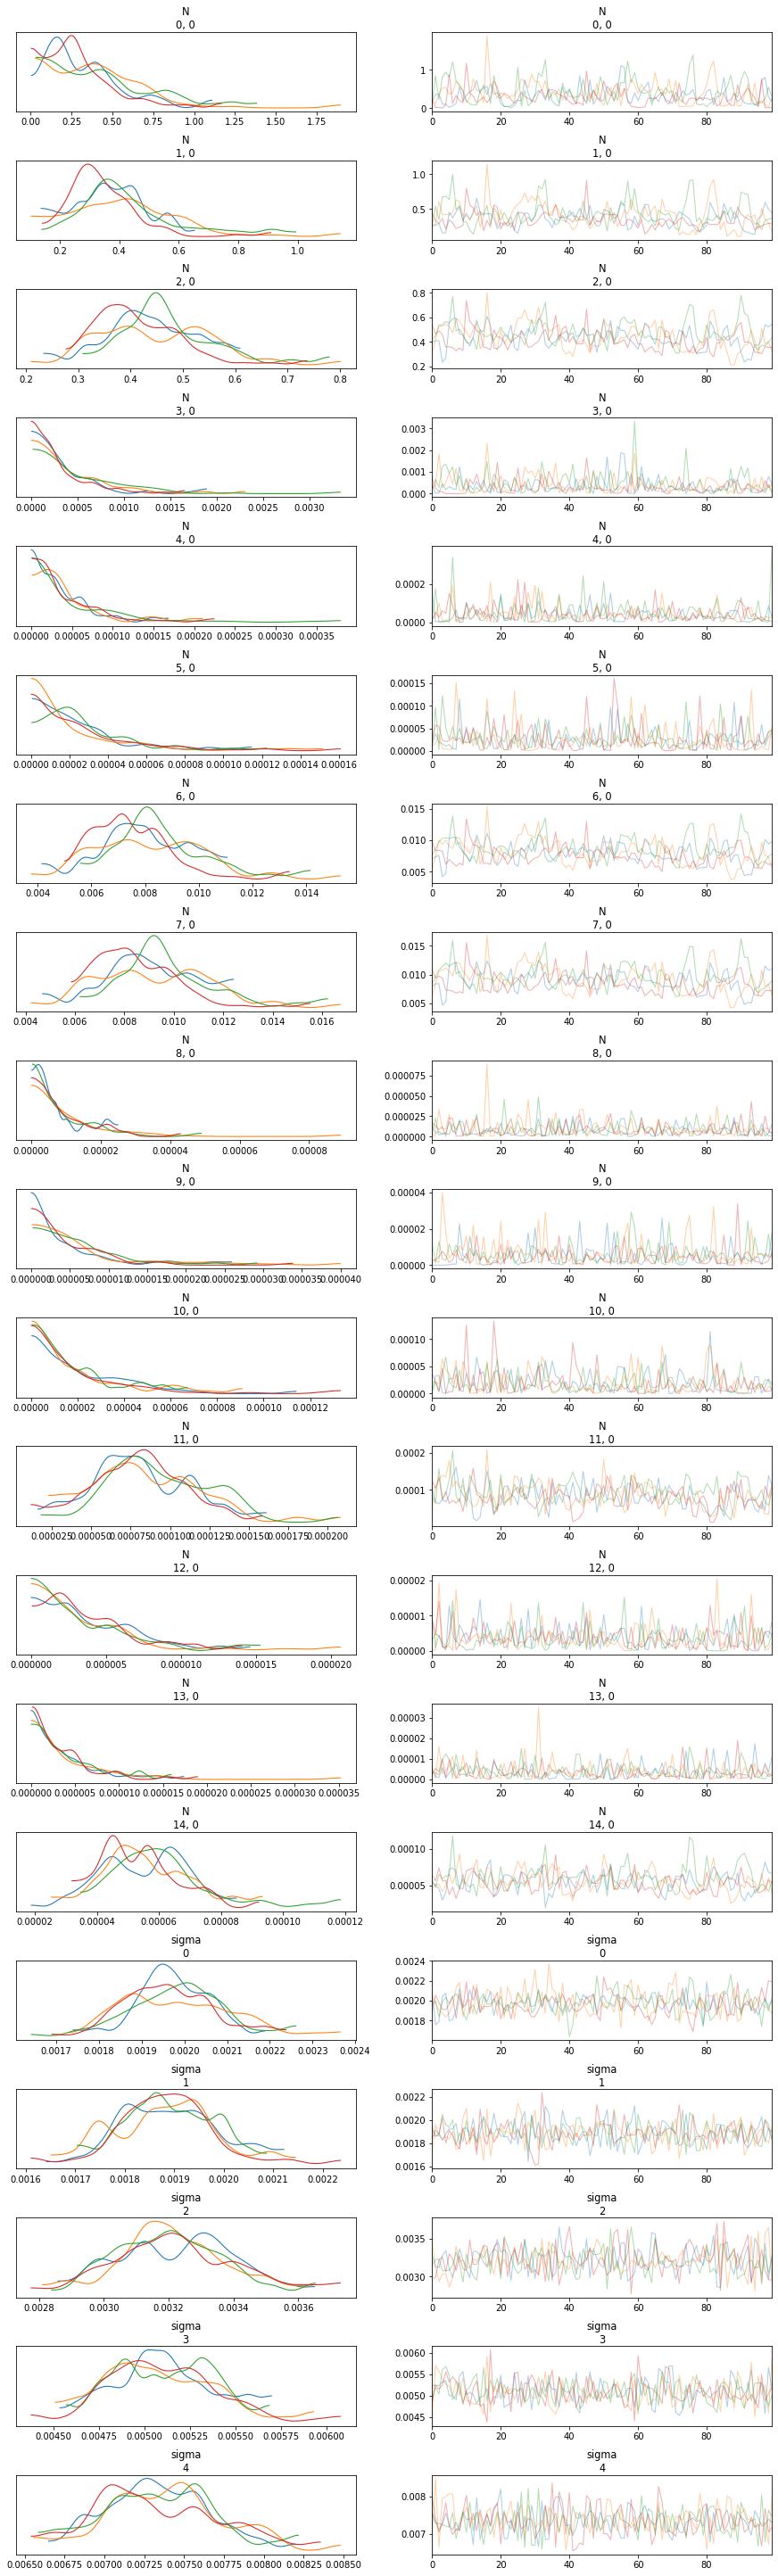

In [16]:
az.plot_trace(trace)

In [17]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"N[0,0]",0.364,0.272,0.005,0.842,0.019,0.013,212.0,212.0,174.0,153.0,1.03
"N[1,0]",0.390,0.156,0.105,0.637,0.013,0.009,153.0,153.0,144.0,140.0,1.04
"N[2,0]",0.443,0.095,0.300,0.622,0.008,0.006,146.0,146.0,139.0,263.0,1.05
"N[3,0]",0.000,0.000,0.000,0.001,0.000,0.000,296.0,296.0,216.0,159.0,1.03
"N[4,0]",0.000,0.000,0.000,0.000,0.000,0.000,598.0,472.0,417.0,233.0,1.02
"N[5,0]",0.000,0.000,0.000,0.000,0.000,0.000,530.0,464.0,347.0,221.0,1.00
"N[6,0]",0.008,0.002,0.005,0.011,0.000,0.000,143.0,143.0,136.0,223.0,1.05
"N[7,0]",0.009,0.002,0.006,0.012,0.000,0.000,145.0,145.0,137.0,204.0,1.04
"N[8,0]",0.000,0.000,0.000,0.000,0.000,0.000,683.0,476.0,652.0,365.0,1.01
"N[9,0]",0.000,0.000,0.000,0.000,0.000,0.000,513.0,422.0,278.0,148.0,1.02


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f971f91c8d0>,
      dtype=object)

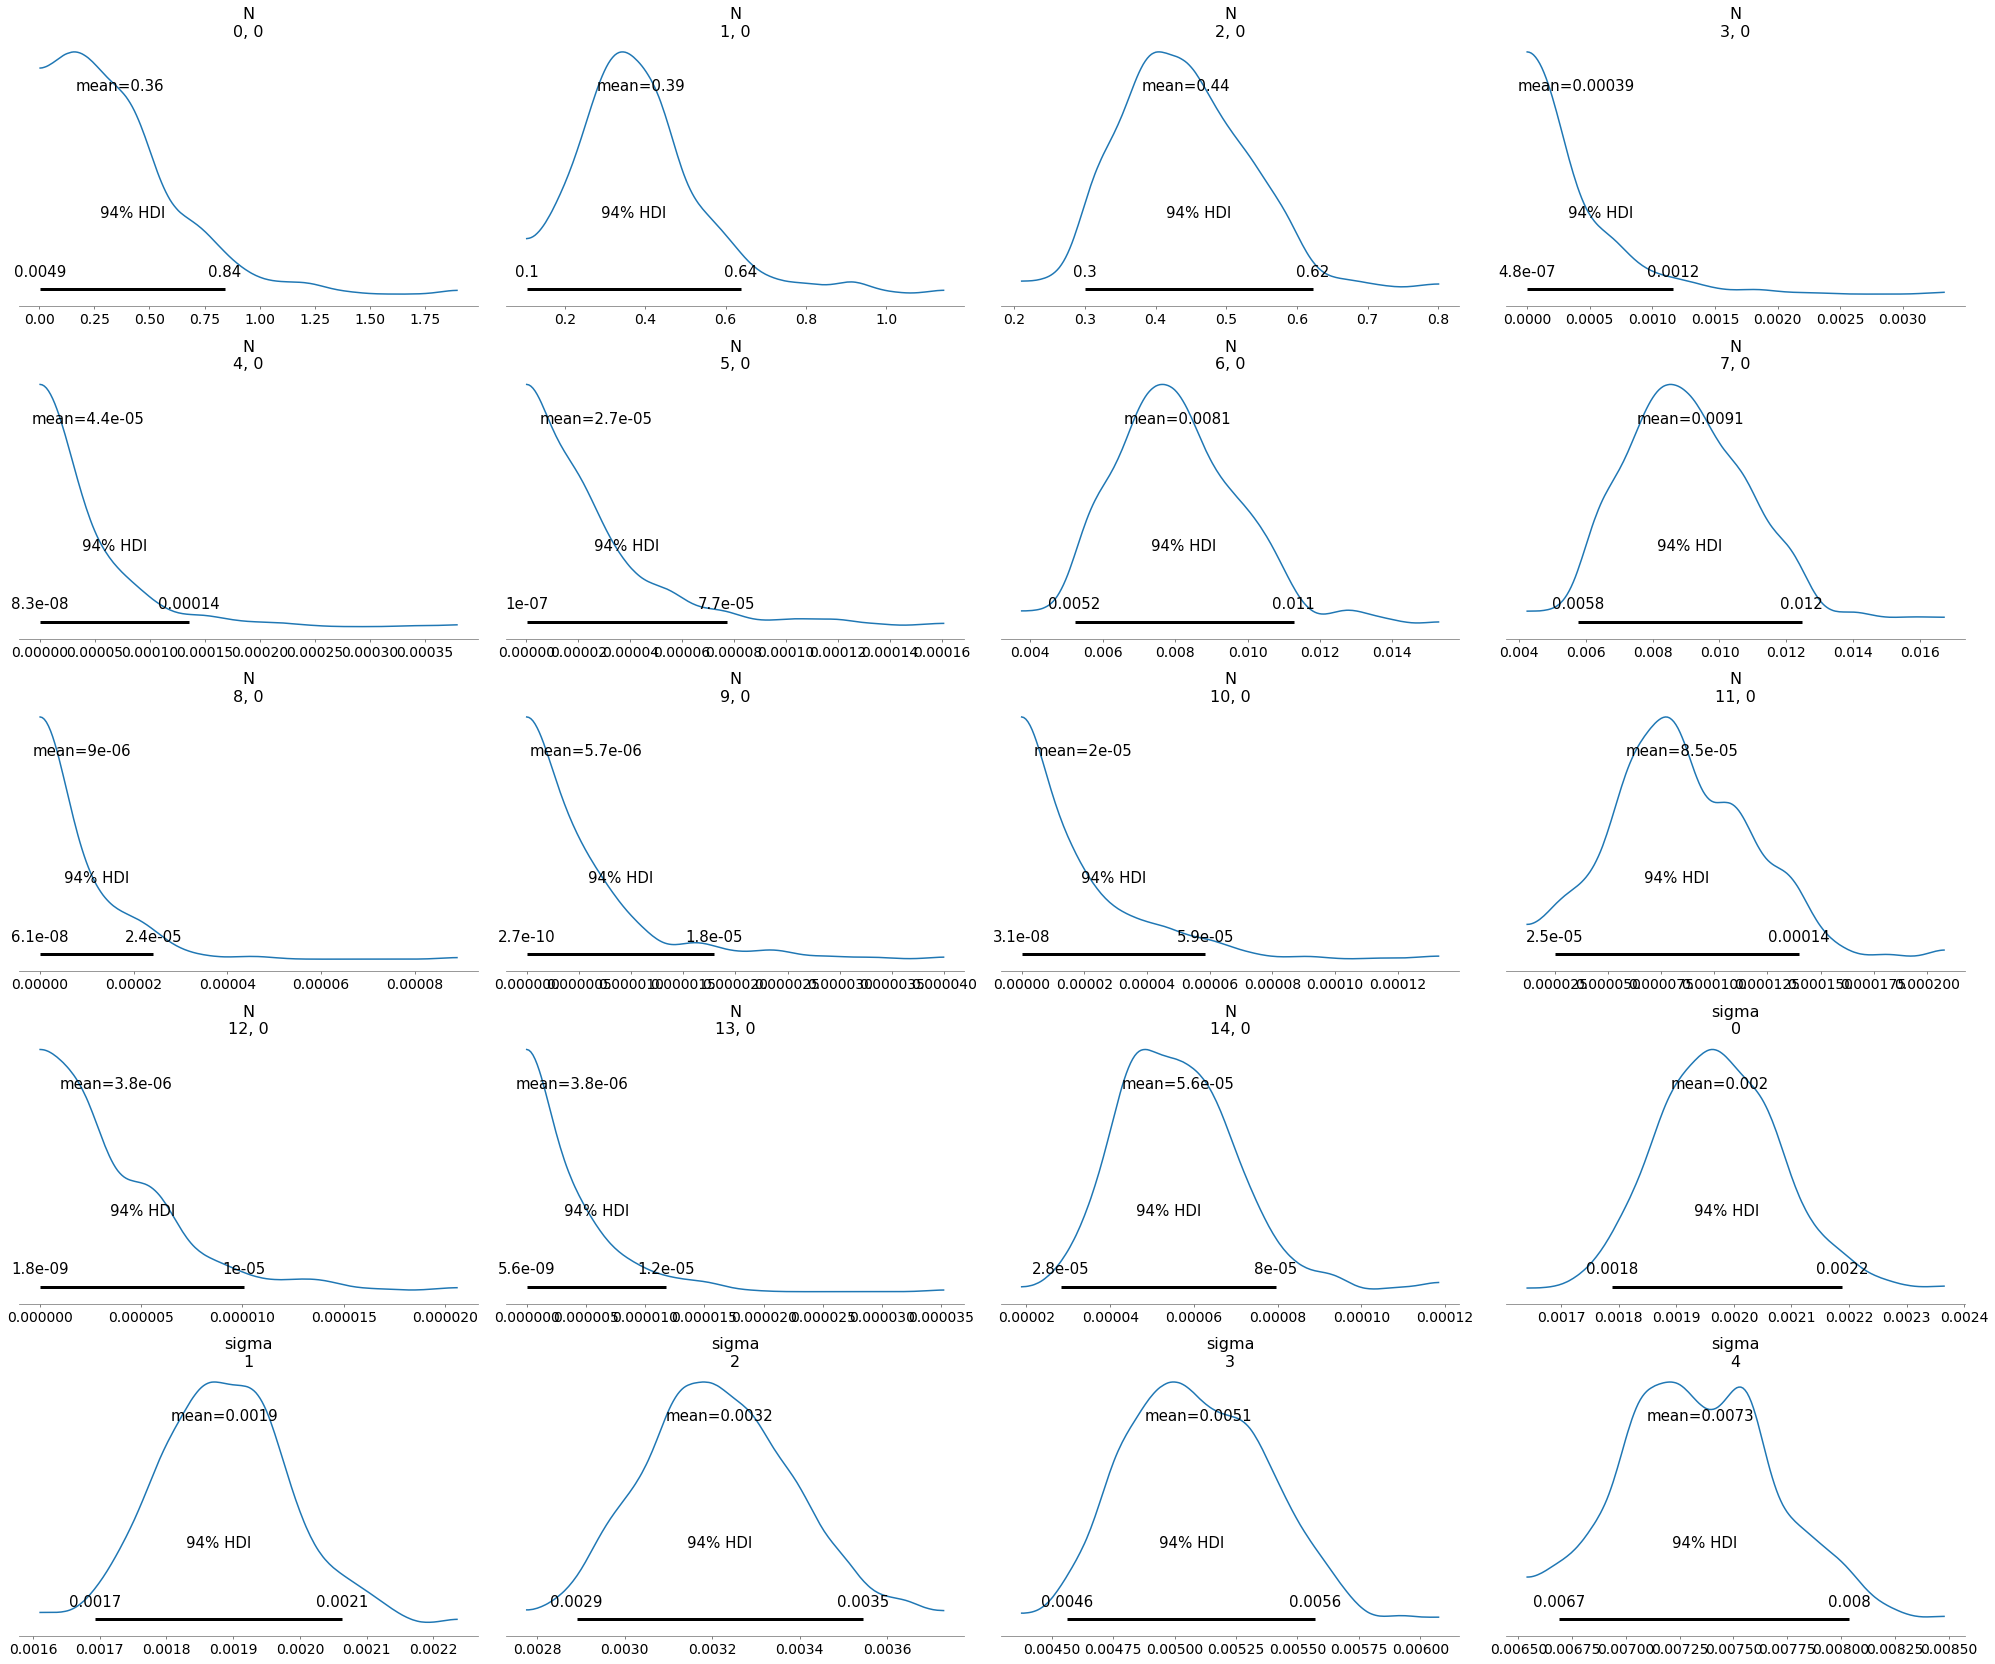

In [18]:
az.plot_posterior(trace)

In [23]:
with pm.Model() as model2:
    test_trace = pm.load_trace('./result_trace/PS_100-200-500nm=1-1-5__trace_d-0-800-30pts_mcmc500k-50k')

In [26]:
test_trace

<MultiTrace: 10 chains, 50000 iterations, 0 variables>